In [ ]:
# =========================
# Cell 0 — Notebook Header
# =========================

"""
Daylight Studio: Sun Path & Ray-Cast Daylight Visualizer

What this notebook does:
- Takes site coordinates and building orientation
- Computes sun positions over a day
- Generates sun path diagrams
- Simulates simple direct daylight penetration using ray-casting
- Outputs plan heatmaps and daily exposure maps

Assumptions:
- Simple rectangular building mass (plus optional context blocks)
- Direct sun only (no diffuse sky, no reflections)
- Clear sky, no weather model
"""


'\nDaylight Studio: Sun Path & Ray-Cast Daylight Visualizer\n\nWhat this notebook does:\n- Takes site coordinates and building orientation\n- Computes sun positions over a day\n- Generates sun path diagrams\n- Simulates simple direct daylight penetration using ray-casting\n- Outputs plan heatmaps and daily exposure maps\n\nAssumptions:\n- Simple rectangular building mass (plus optional context blocks)\n- Direct sun only (no diffuse sky, no reflections)\n- Clear sky, no weather model\n'

In [ ]:
# ==================================
# Cell 1 — Install & Import Packages
# ==================================

# If running in Colab, uncomment installs as needed:
# !pip install numpy pandas matplotlib shapely

import math
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, Point, LineString
from shapely.affinity import rotate, translate

plt.style.use("seaborn-v0_8")

In [ ]:
# ==========================
# Cell 2 — User Input Panel
# ==========================

# ---- Location & time inputs ----
latitude = 51.5074      # London example
longitude = -0.1278

# Building orientation (degrees from North, clockwise)
# 0 = facing North, 90 = facing East, etc.
building_orientation_deg = 30.0

# Date and time range
date = dt.date(2024, 6, 21)   # Summer solstice example
time_start = dt.time(8, 0)
time_end   = dt.time(18, 0)
time_step_minutes = 60        # step in minutes

# ---- Building geometry (rectangular mass) ----
# Local coordinate system, building centered at (0,0)
building_length = 20.0   # along local x
building_width  = 10.0   # along local y
building_height = 12.0   # total height in meters

# ---- Optional context blocks (simple list) ----
# Each context block: (center_x, center_y, length, width, height)
context_blocks = [
    # Example: a block to the south
    # (0.0, -25.0, 30.0, 10.0, 15.0)
]

# ---- Analysis grid ----
grid_step = 1.0          # meters
analysis_plane_height = 0.8  # meters above floor

# ---- Misc ----
timezone_offset_hours = 0  # simple offset if you want to tweak local time

In [ ]:
# ==================================
# Cell 3 — Solar Position Functions
# ==================================

def datetime_range(date, start_time, end_time, step_minutes):
    """Generate datetimes for a single date between start and end time."""
    start_dt = dt.datetime.combine(date, start_time)
    end_dt   = dt.datetime.combine(date, end_time)
    step = dt.timedelta(minutes=step_minutes)
    times = []
    t = start_dt
    while t <= end_dt:
        times.append(t)
        t += step
    return times


def solar_position_simple(lat_deg, lon_deg, when_utc):
    """
    Very simplified solar position algorithm.
    Returns solar altitude and azimuth in degrees.
    Good enough for conceptual visualization, not for engineering-grade analysis.
    """
    # Convert to radians
    lat = math.radians(lat_deg)

    # Days from J2000
    epoch = dt.datetime(2000, 1, 1, 12, 0, 0)
    delta = (when_utc - epoch).total_seconds() / 86400.0

    # Mean anomaly and ecliptic longitude (simplified)
    mean_long = (280.46 + 0.9856474 * delta) % 360
    mean_anom = math.radians((357.528 + 0.9856003 * delta) % 360)
    eclip_long = math.radians(
        (mean_long + 1.915 * math.sin(mean_anom) + 0.020 * math.sin(2 * mean_anom)) % 360
    )

    # Obliquity of the ecliptic
    obliq = math.radians(23.439 - 0.0000004 * delta)

    # Sun declination
    sin_dec = math.sin(obliq) * math.sin(eclip_long)
    dec = math.asin(sin_dec)

    # Equation of time (very rough)
    y = math.tan(obliq / 2) ** 2
    eq_time = 4 * math.degrees(
        y * math.sin(2 * eclip_long)
        - 2 * 0.0167 * math.sin(mean_anom)
        + 4 * 0.0167 * y * math.sin(mean_anom) * math.cos(2 * eclip_long)
        - 0.5 * y**2 * math.sin(4 * eclip_long)
        - 1.25 * 0.0167**2 * math.sin(2 * mean_anom)
    )

    # Local solar time
    offset = lon_deg * 4  # minutes from UTC
    true_solar_time_min = (
        when_utc.hour * 60 + when_utc.minute + when_utc.second / 60 + eq_time + offset
    ) % 1440

    # Hour angle
    if true_solar_time_min / 4 < 0:
        ha_deg = true_solar_time_min / 4 + 180
    else:
        ha_deg = true_solar_time_min / 4 - 180
    ha = math.radians(ha_deg)

    # Solar zenith angle
    cos_zenith = math.sin(lat) * math.sin(dec) + math.cos(lat) * math.cos(dec) * math.cos(ha)
    cos_zenith = max(min(cos_zenith, 1.0), -1.0)
    zenith = math.acos(cos_zenith)
    altitude = math.degrees(math.pi / 2 - zenith)

    # Solar azimuth (from North, clockwise)
    sin_az = -math.sin(ha) * math.cos(dec) / math.sin(zenith) if math.sin(zenith) != 0 else 0
    cos_az = (math.sin(dec) - math.sin(lat) * math.cos(zenith)) / (math.cos(lat) * math.sin(zenith) + 1e-9)
    azimuth = math.degrees(math.atan2(sin_az, cos_az))
    azimuth = (azimuth + 360) % 360

    return altitude, azimuth


def sun_vector_from_alt_az(alt_deg, az_deg):
    """
    Convert solar altitude and azimuth (deg) to a 3D unit vector.
    Azimuth: 0 = North, 90 = East.
    """
    alt = math.radians(alt_deg)
    az = math.radians(az_deg)

    # Coordinate system: x = East, y = North, z = Up
    x = math.cos(alt) * math.sin(az)
    y = math.cos(alt) * math.cos(az)
    z = math.sin(alt)
    return np.array([x, y, z], dtype=float)

In [ ]:
# ==========================================
# Cell 4 — Generate Time Series & DataFrame
# ==========================================

# Build list of datetimes (assume input is local; adjust to UTC by offset)
local_times = datetime_range(date, time_start, time_end, time_step_minutes)
times_utc = [t - dt.timedelta(hours=timezone_offset_hours) for t in local_times]

records = []
for local_t, utc_t in zip(local_times, times_utc):
    alt, az = solar_position_simple(latitude, longitude, utc_t)
    records.append(
        {
            "local_time": local_t,
            "utc_time": utc_t,
            "altitude_deg": alt,
            "azimuth_deg": az,
        }
    )

sun_df = pd.DataFrame(records)
sun_df

,local_time,utc_time,altitude_deg,azimuth_deg
0,2024-06-21 08:00:00,2024-06-21 08:00:00,36.248384,97.450761
1,2024-06-21 09:00:00,2024-06-21 09:00:00,45.279451,111.208229
2,2024-06-21 10:00:00,2024-06-21 10:00:00,53.379643,128.375272
3,2024-06-21 11:00:00,2024-06-21 11:00:00,59.450481,150.869960
4,2024-06-21 12:00:00,2024-06-21 12:00:00,61.922213,178.738877
5,2024-06-21 13:00:00,2024-06-21 13:00:00,59.828417,206.903519
6,2024-06-21 14:00:00,2024-06-21 14:00:00,54.002819,229.918372
7,2024-06-21 15:00:00,2024-06-21 15:00:00,46.025921,247.471284
8,2024-06-21 16:00:00,2024-06-21 16:00:00,37.044728,261.452011
9,2024-06-21 17:00:00,2024-06-21 17:00:00,27.735096,273.478469


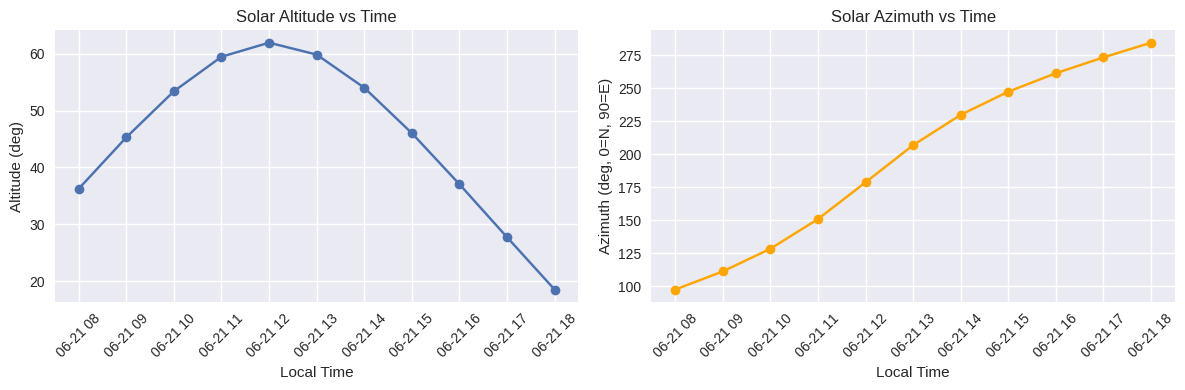

In [ ]:
# ===================================
# Cell 5 — Sun Altitude & Azimuth Plots
# ===================================

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Altitude vs time
ax[0].plot(sun_df["local_time"], sun_df["altitude_deg"], marker="o")
ax[0].set_title("Solar Altitude vs Time")
ax[0].set_ylabel("Altitude (deg)")
ax[0].set_xlabel("Local Time")
ax[0].grid(True)
ax[0].tick_params(axis="x", rotation=45)

# Azimuth vs time
ax[1].plot(sun_df["local_time"], sun_df["azimuth_deg"], marker="o", color="orange")
ax[1].set_title("Solar Azimuth vs Time")
ax[1].set_ylabel("Azimuth (deg, 0=N, 90=E)")
ax[1].set_xlabel("Local Time")
ax[1].grid(True)
ax[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

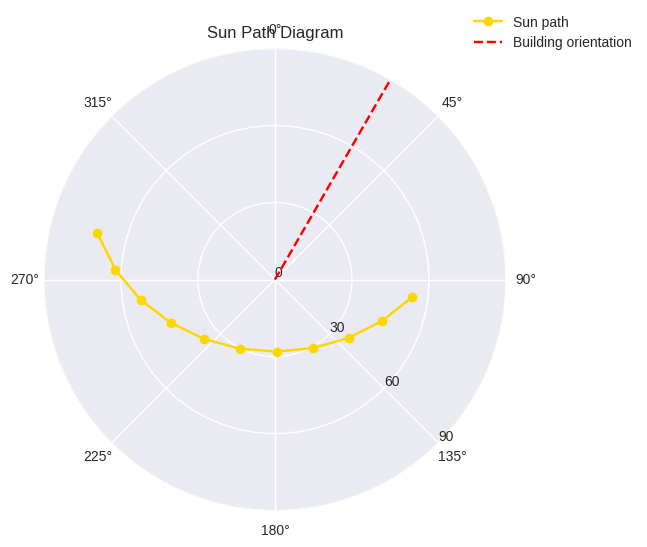

In [ ]:
# ================================
# Cell 6 — Sun Path Polar Diagram
# ================================

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

# Convert azimuth (deg from North, clockwise) to polar angle (rad from East, CCW)
# Matplotlib polar: 0 rad = East, CCW positive
# We'll instead set 0 at North and clockwise direction.
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

theta = np.radians(sun_df["azimuth_deg"].values)
r = 90 - sun_df["altitude_deg"].values  # use (90 - altitude) as radial distance

ax.plot(theta, r, marker="o", linestyle="-", color="gold", label="Sun path")

# Mark building orientation
building_theta = math.radians(building_orientation_deg)
ax.plot([building_theta, building_theta], [0, 90], color="red", linestyle="--", label="Building orientation")

ax.set_rmax(90)
ax.set_rticks([0, 30, 60, 90])
ax.set_rlabel_position(135)
ax.set_title("Sun Path Diagram", va="bottom")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()

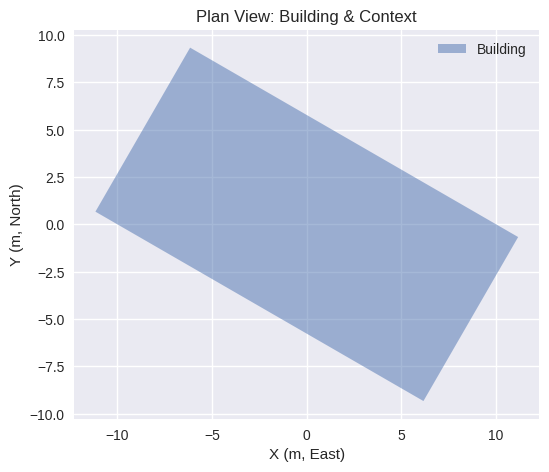

In [ ]:
# ============================
# Cell 7 — Geometry Definition
# ============================

# Building footprint centered at (0,0) before rotation
half_L = building_length / 2
half_W = building_width / 2

base_polygon = Polygon(
    [
        (-half_L, -half_W),
        ( half_L, -half_W),
        ( half_L,  half_W),
        (-half_L,  half_W),
    ]
)

# Rotate footprint by building orientation (around origin)
# building_orientation_deg is from North; our x-axis is East, y-axis is North.
# For plan rotation, we rotate polygon by -orientation around origin in degrees.
footprint = rotate(base_polygon, -building_orientation_deg, origin=(0, 0), use_radians=False)

# Context blocks as polygons with heights
context_polygons = []
for cx, cy, L, W, H in context_blocks:
    hL = L / 2
    hW = W / 2
    poly = Polygon(
        [
            (cx - hL, cy - hW),
            (cx + hL, cy - hW),
            (cx + hL, cy + hW),
            (cx - hL, cy + hW),
        ]
    )
    context_polygons.append((poly, H))

# Quick plan preview
fig, ax = plt.subplots(figsize=(6, 6))
x, y = footprint.exterior.xy
ax.fill(x, y, alpha=0.5, label="Building")

for poly, H in context_polygons:
    cx, cy = poly.exterior.xy
    ax.fill(cx, cy, alpha=0.3, color="gray", label=f"Context (h={H}m)")

ax.set_aspect("equal", "box")
ax.set_xlabel("X (m, East)")
ax.set_ylabel("Y (m, North)")
ax.set_title("Plan View: Building & Context")
ax.grid(True)
plt.legend()
plt.show()

Number of analysis points: 200


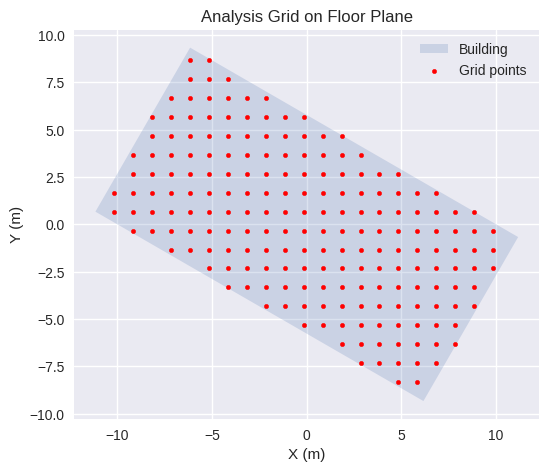

In [ ]:
# ==================================
# Cell 8 — Analysis Grid Generation
# ==================================

minx, miny, maxx, maxy = footprint.bounds

xs = np.arange(minx, maxx + grid_step, grid_step)
ys = np.arange(miny, maxy + grid_step, grid_step)

grid_points = []
grid_indices = []  # (ix, iy) for reshaping later

for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        p = Point(x, y)
        if footprint.contains(p):
            grid_points.append((x, y, analysis_plane_height))
            grid_indices.append((i, j))

grid_points = np.array(grid_points)
print(f"Number of analysis points: {len(grid_points)}")

# Quick visualization of grid
fig, ax = plt.subplots(figsize=(6, 6))
x, y = footprint.exterior.xy
ax.fill(x, y, alpha=0.2, label="Building")

if len(grid_points) > 0:
    ax.scatter(grid_points[:, 0], grid_points[:, 1], s=10, c="red", label="Grid points")

ax.set_aspect("equal", "box")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_title("Analysis Grid on Floor Plane")
ax.grid(True)
plt.legend()
plt.show()

In [ ]:
# ============================
# Cell 9 — Ray-Casting Helpers
# ============================

def line_intersects_prism_2d(line, polygon, height, z0, sun_vec):
    """
    Very simplified intersection test:
    - We only check 2D intersection in plan.
    - Then check if the sun ray would hit the vertical extent [0, height].
    This is conceptual, not physically exact.
    """
    if not line.intersects(polygon):
        return False

    # If the ray is going downward (z component <= 0), no direct sun
    if sun_vec[2] <= 0:
        return True  # treat as blocked (sun below horizon)

    # For conceptual purposes, if it intersects in plan and building is taller than plane, we treat as blocked.
    if height > z0:
        return True

    return False


def is_point_lit(point_xyz, sun_vec, building_poly, building_height, context_polys):
    """
    Check if a point is lit by direct sun:
    - point_xyz: (x, y, z)
    - sun_vec: unit vector (x, y, z) from point toward sun
    - building_poly: building footprint
    - context_polys: list of (polygon, height)
    """
    x0, y0, z0 = point_xyz
    # If sun below horizon, no light
    if sun_vec[2] <= 0:
        return False

    # Create a long ray in plan from point in direction of sun_vec
    # We only use x,y for intersection; z handled conceptually.
    ray_length = 1000.0
    x1 = x0 + sun_vec[0] * ray_length
    y1 = y0 + sun_vec[1] * ray_length

    ray_line = LineString([(x0, y0), (x1, y1)])

    # Check intersection with building itself (excluding a tiny buffer around the point)
    if line_intersects_prism_2d(ray_line, building_poly, building_height, z0, sun_vec):
        return False

    # Check context blocks
    for poly, H in context_polys:
        if line_intersects_prism_2d(ray_line, poly, H, z0, sun_vec):
            return False

    return True

In [ ]:
# ================================
# Cell 10 — Run Daylight Simulation
# ================================

num_times = len(sun_df)
num_points = len(grid_points)

results = np.zeros((num_times, num_points), dtype=int)

for t_idx, row in sun_df.iterrows():
    alt = row["altitude_deg"]
    az = row["azimuth_deg"]
    sun_vec = sun_vector_from_alt_az(alt, az)

    for p_idx, pt in enumerate(grid_points):
        lit = is_point_lit(pt, sun_vec, footprint, building_height, context_polygons)
        results[t_idx, p_idx] = 1 if lit else 0

results.shape

(11, 200)

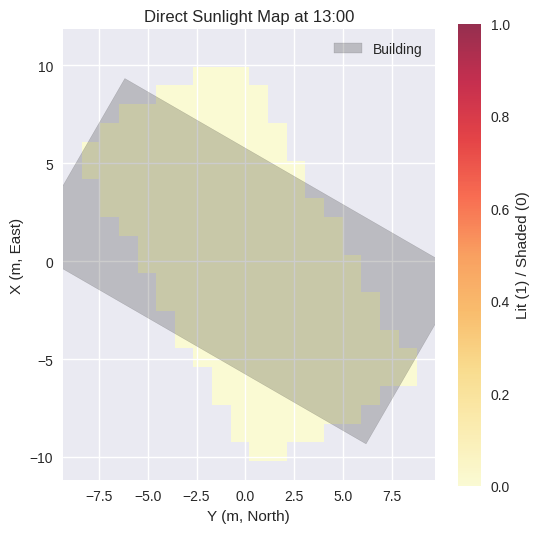

In [ ]:
# ==================================
# Cell 11 — Single Time-Step Heatmap
# ==================================

# Choose a time index to visualize
time_index_to_plot = num_times // 2  # middle of the day
selected_time = sun_df.iloc[time_index_to_plot]["local_time"]

# Build a 2D grid initialized with NaN
heatmap = np.full((len(xs), len(ys)), np.nan)

for idx, (ix, iy) in enumerate(grid_indices):
    heatmap[ix, iy] = results[time_index_to_plot, idx]

fig, ax = plt.subplots(figsize=(6, 6))

# Plot building footprint
bx, by = footprint.exterior.xy
ax.fill(bx, by, alpha=0.2, color="black", label="Building")

# Plot heatmap
X, Y = np.meshgrid(ys, xs)  # note order for imshow vs coordinates
im = ax.imshow(
    heatmap,
    origin="lower",
    extent=[min(ys), max(ys), min(xs), max(xs)],
    cmap="YlOrRd",
    vmin=0,
    vmax=1,
    alpha=0.8,
)

plt.colorbar(im, ax=ax, label="Lit (1) / Shaded (0)")
ax.set_aspect("equal", "box")
ax.set_xlabel("Y (m, North)")
ax.set_ylabel("X (m, East)")
ax.set_title(f"Direct Sunlight Map at {selected_time.strftime('%H:%M')}")
ax.grid(True)
plt.legend()
plt.show()

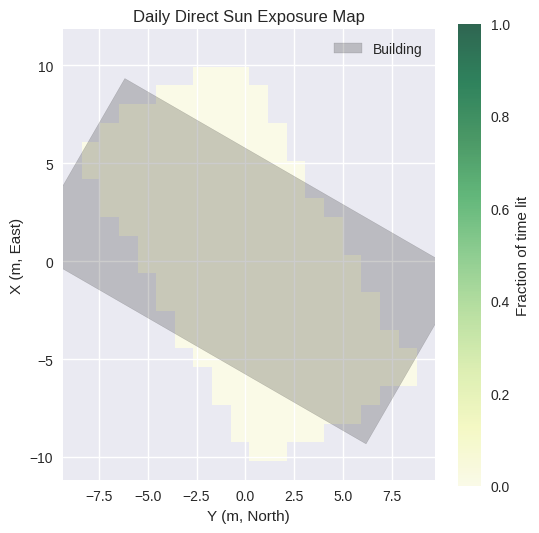

Average exposure fraction over floor: 0.00


In [ ]:
# ==============================
# Cell 12 — Daily Exposure Map
# ==============================

# Fraction of time lit for each point
exposure_fraction = results.sum(axis=0) / num_times

# Map to 2D grid
exposure_map = np.full((len(xs), len(ys)), np.nan)
for idx, (ix, iy) in enumerate(grid_indices):
    exposure_map[ix, iy] = exposure_fraction[idx]

fig, ax = plt.subplots(figsize=(6, 6))

bx, by = footprint.exterior.xy
ax.fill(bx, by, alpha=0.2, color="black", label="Building")

X, Y = np.meshgrid(ys, xs)
im = ax.imshow(
    exposure_map,
    origin="lower",
    extent=[min(ys), max(ys), min(xs), max(xs)],
    cmap="YlGn",
    vmin=0,
    vmax=1,
    alpha=0.8,
)

plt.colorbar(im, ax=ax, label="Fraction of time lit")
ax.set_aspect("equal", "box")
ax.set_xlabel("Y (m, North)")
ax.set_ylabel("X (m, East)")
ax.set_title("Daily Direct Sun Exposure Map")
ax.grid(True)
plt.legend()
plt.show()

# Simple metrics
avg_exposure = np.nanmean(exposure_map)
print(f"Average exposure fraction over floor: {avg_exposure:.2f}")

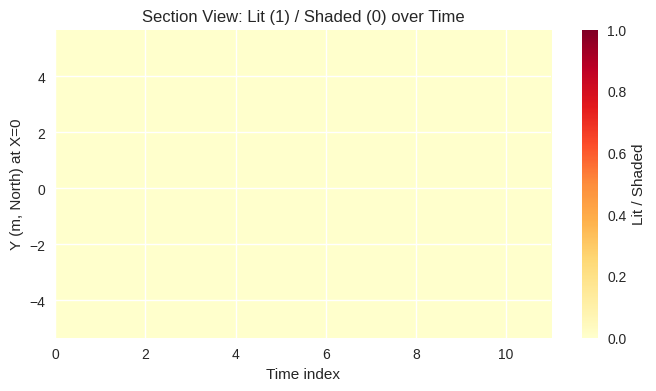

In [ ]:
# ===================================
# Cell 13 — Simple Section View (Optional)
# ===================================

# Choose a slice along x (or y). Here: slice along x=0 (vertical line through origin).
slice_x = 0.0
tolerance = grid_step / 2

slice_points_idx = []
slice_points_y = []

for idx, (x, y, z) in enumerate(grid_points):
    if abs(x - slice_x) <= tolerance:
        slice_points_idx.append(idx)
        slice_points_y.append(y)

slice_points_idx = np.array(slice_points_idx)
slice_points_y = np.array(slice_points_y)

# Sort by y
order = np.argsort(slice_points_y)
slice_points_idx = slice_points_idx[order]
slice_points_y = slice_points_y[order]

# Build a time vs distance matrix
section_matrix = results[:, slice_points_idx]  # shape: (time, points)

fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(
    section_matrix.T,
    aspect="auto",
    origin="lower",
    cmap="YlOrRd",
    vmin=0,
    vmax=1,
    extent=[0, num_times, slice_points_y[0], slice_points_y[-1]],
)

ax.set_xlabel("Time index")
ax.set_ylabel("Y (m, North) at X=0")
ax.set_title("Section View: Lit (1) / Shaded (0) over Time")
plt.colorbar(im, ax=ax, label="Lit / Shaded")
plt.show()

In [ ]:
# ==========================
# Cell 14 — Export Outputs
# ==========================

import os

output_folder = "daylight_outputs"
os.makedirs(output_folder, exist_ok=True)

# Save sun_df
sun_df.to_csv(os.path.join(output_folder, "sun_positions.csv"), index=False)

# Save exposure map as CSV
exposure_df_records = []
for idx, (ix, iy) in enumerate(grid_indices):
    x = xs[ix]
    y = ys[iy]
    exposure_df_records.append({"x": x, "y": y, "exposure_fraction": exposure_fraction[idx]})

exposure_df = pd.DataFrame(exposure_df_records)
exposure_df.to_csv(os.path.join(output_folder, "exposure_map.csv"), index=False)

print(f"Data exported to folder: {output_folder}")

Data exported to folder: daylight_outputs


In [ ]:
# ==============================
# Cell 15 — Auto-Generated Report
# ==============================

report_lines = []

report_lines.append("# Daylight Studio — Summary Report\n")
report_lines.append(f"- **Location:** lat {latitude:.4f}, lon {longitude:.4f}")
report_lines.append(f"- **Date:** {date.isoformat()}")
report_lines.append(f"- **Time range:** {time_start.strftime('%H:%M')}–{time_end.strftime('%H:%M')} (step {time_step_minutes} min)")
report_lines.append(f"- **Building orientation:** {building_orientation_deg:.1f}° from North (clockwise)")
report_lines.append(f"- **Building size:** {building_length} m × {building_width} m × {building_height} m")
report_lines.append(f"- **Analysis plane height:** {analysis_plane_height} m")
report_lines.append(f"- **Grid step:** {grid_step} m")
report_lines.append(f"- **Number of analysis points:** {num_points}")
report_lines.append(f"- **Average exposure fraction:** {avg_exposure:.2f}")

report_md = "\n".join(report_lines)
print(report_md)

# Daylight Studio — Summary Report

- **Location:** lat 51.5074, lon -0.1278
- **Date:** 2024-06-21
- **Time range:** 08:00–18:00 (step 60 min)
- **Building orientation:** 30.0° from North (clockwise)
- **Building size:** 20.0 m × 10.0 m × 12.0 m
- **Analysis plane height:** 0.8 m
- **Grid step:** 1.0 m
- **Number of analysis points:** 200
- **Average exposure fraction:** 0.00
